<a href="https://colab.research.google.com/github/karanrj01/Machine-Learning-Project-19AIE205-/blob/main/Image_Dehazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Image Dehazing Using Dark Channel Prior 



### 19AIE205 Project
### Group No. - 7

The input hazed image and clear image both obtained from the datasets are already uploaded. 

Importing the necessary python libraries for preprocessing and calculation

In [150]:
import cv2;
import math;
import numpy as np;
from google.colab.patches import cv2_imshow
import matplotlib.pylab as plt

In [151]:
def bgr2rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

The input **hazed image** is shown below. The objective is to remove the haze that covers the foreground. 

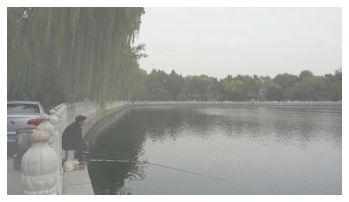

In [152]:
fn = '3146.jpg'
src = cv2.imread(fn);
I = src.astype('float64')

img = bgr2rgb(src)
plt.imshow(img)
plt.axis("off");

The whole process for Image Dehazing is shown below and each step is done in order.

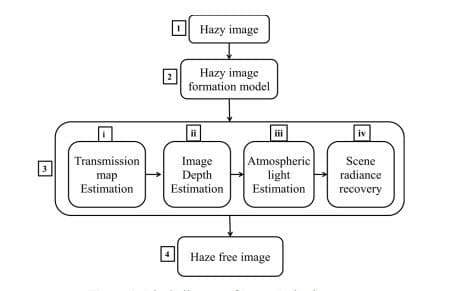

To model the formation of the hazed image, we use the equation 

$$I(x) = J(x)t(x) + A(1 - t(x))$$

where 
*   $I$ - observed intensity
*   $J$ - scene radiance
*   $A$ - global atmospheric light
*   $t$ - medium transmission


Naturally , the haze image is a linear combination of the scene radiance and scattered atmospheric light. If we can recover $A$ and $t$ from the hazed image, then we can use this model to solve for $J$, the unhazed image.

The histogram below shows the **pixel value in each of RGB colour channel** of the input hazed image 

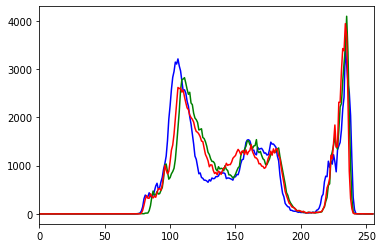

In [153]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([src],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

##  Dark Channel Prior
The dark channel prior is defined as: $$J^{dark}(x) = \min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(J^{c}(y)))$$

$\mathbf{J}$ is our image, $J^{c}$ is defined as a color channel of our image (one of red, blue, or green), and $\Omega(x)$ is a patch of pixels centered at $x$. 

Intuitively, $J^{dark}$ should be low in a haze-free region of the image. Colorful objects will lack intensity in at least one color channel, resulting in a low $J^{dark}$. However, in the lighter colors in the sky regions of the image will have higher $J^{dark}$. We'll use this information later to estimate the atmospheric light.

In [154]:
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark


dark = DarkChannel(I,15);

The image displayed is obtained after the dark channel prior. In the foreground, the dark channel prior has low intensity, while in the sky regions, the intensity is high.

(-0.5, 549.5, 308.5, -0.5)

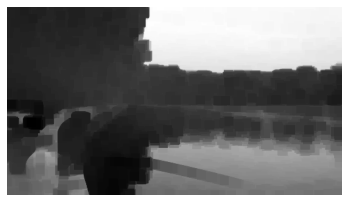

In [155]:
plt.imshow(dark, cmap='gray')
plt.axis("off")

The histogram below shows the pixel values of the dark channel of the input image, which is calculated by storing the min of each of pixel values at each colur channel.

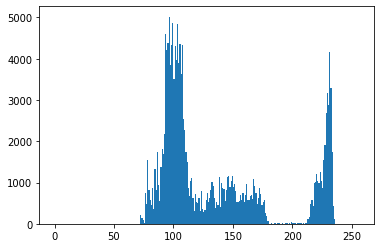

In [156]:
plt.hist((dark).ravel(),bins = 256, range = [0,256]) 
plt.show()

## Atmospheric Light Estimation

Assuming that the atmospheric light is a constant for each channel. And, we calculate the atmospheric light for each channel in the image $A^{c}$, indicating that $A$ is different depending on what channel that is being used in the calculations.

In [157]:
def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = np.argsort(darkvec,axis=0);
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

A = AtmLight(I,dark);

Here, we replicate the detection of atmospheric light. The pixels we inspect for the atmospheric light (shown in blue). Since the pixels of these patches show the highest pixel value, these are taken for tranmission map estimation.  

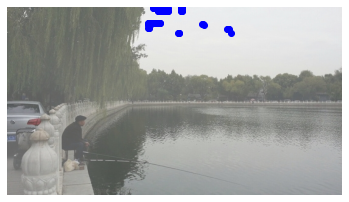

In [158]:
size = I.shape[:2]
k = int(0.001*np.prod(size))
idx = np.argpartition(-dark.ravel(),k)[:k]
zz = np.column_stack(np.unravel_index(idx, dark.shape))
x, y = np.hsplit(zz,2)
plt.imshow(img)
plt.scatter(y, x, c='b')
plt.axis('off')
plt.show();

##Transmission Map Estimation 
We calculate the transmission $\bar{t}(x)$ through the equation, 

$$\bar{t}(x) = 1 - \omega\min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(\frac{J^{c}(y)}{A^{c}}))$$

Finally, after normalizing the image using the atmospheric light, we know the value of atmospheric light that defines each pixel. From the model of the hazed image, we know that the hazed image is a linear combination of the atmospheric light and the original unhazed image. So, we can do 1 - this value to recover the original image numbers that defines each pixel.

In [159]:
def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

te = TransmissionEstimate(I,A,15);

## Transmission Map Refinement 

The tranmission map obtained after estimation will contain some noise and unrefined patches. Guided Filter is used inorder to obtain refinement.

Since most features are clearly based on just intensity, refinement has been done in grayscale channel. Since only a little difference was seen when comparing RGB and grayscale. However, it is clear that there can be boundaries that will be missed in some images due to foreground and background intensities blending together in the grayscale.

In [160]:
def Guidedfilter(im,p,r,eps):
  
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

t = TransmissionRefine(src,te);


The transmission map refinement is shown below clearly. 

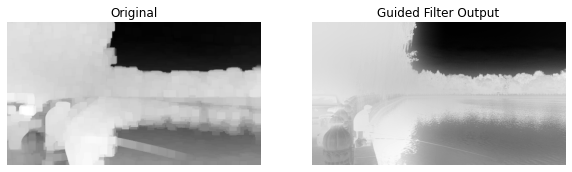

In [161]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

ax1.imshow(te, cmap="gray")
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(t, cmap="gray")
ax2.set_title("Guided Filter Output")
ax2.axis('off');

The final step where the  **output haze free** image $J$ is obtained(Refer 1st equation). 

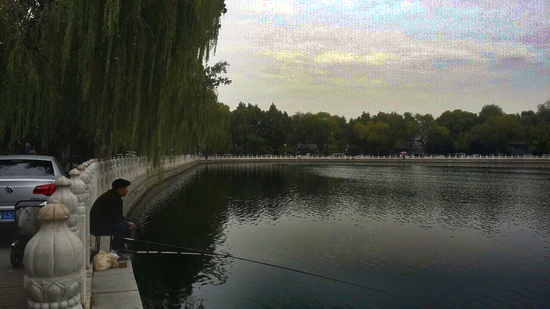

In [162]:
def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

J = Recover(I,t,A,0.1);
cv2_imshow(J)

The **input - hazed** image and the **output - dehazed** image are shown side by side.

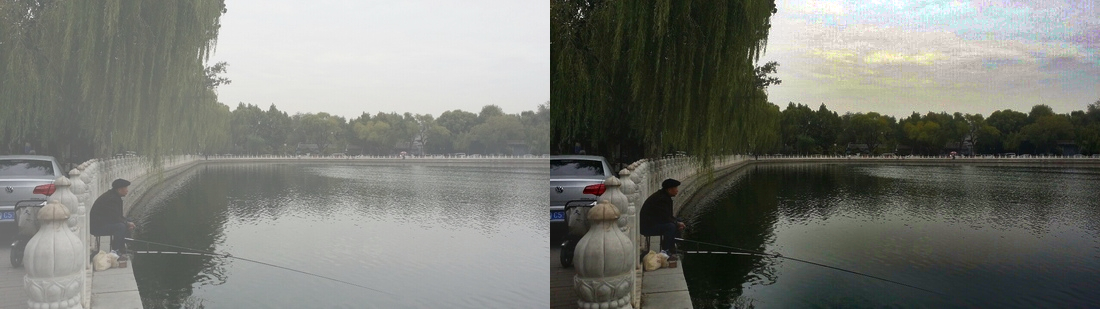

In [163]:
cv2.imwrite("Output.jpg", J)
numpy_horizontal = np.hstack((src, J))
cv2_imshow(numpy_horizontal)

# Validation
For evaluating the result, we have used image comparing metrics like **PSNR** and **SSIM**. We have compared the clear image, given along with the dataset and compared it with output obtained after dehazing.

In [164]:
import math
import numpy as np

img1 = cv2.imread("3146_1.jpg")
img2 = J

def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

print("PSNR:-")    
calculate_psnr(img1, img2)

PSNR:-


18.49045732795386

In [165]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5] 
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

print("SSIM:-")
calculate_ssim(img1, img2)

SSIM:-


0.8275439344996154